# Eğitilmiş modeli kaydetme
Eğitilen modelin gelecekte yeniden kullanılabilir hale getirilmesi ve performansının değerlendirilmesi süreçlerini içerir.

### 1. **Model Kaydetme**
Model kaydetme, eğitilmiş bir modelin tüm ağırlıklarının ve yapısının dosyaya kaydedilmesi işlemidir. Bu, modelin eğitimi tamamlandıktan sonra ileride yeniden yüklenip kullanılabilmesi için yapılır.

### 2. **Model Test Etme**
Model test etme, eğitilmiş modelin performansını değerlendirmek için ayrılmış bir test veri kümesi üzerinde modelin doğruluğunu, kaybını (loss) ve diğer metriklerini hesaplamayı içerir.


Bu süreçler, modelin eğitiminin ardından tekrar eğitmeye gerek kalmadan kullanılabilir olmasını sağlar ve modelin genel performansını anlamamıza yardımcı olur.

In [1]:
!pip install tensorflow tensorflow-addons tensorflow-hub tensorflow-datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


## Rastgele veri seti oluşturma

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Rastgele veri kümesi oluşturma
def create_random_data(num_samples, img_size):
    images = np.random.rand(num_samples, img_size, img_size, 3).astype(np.float32)
    masks = np.random.randint(0, 2, size=(num_samples, img_size, img_size, 1)).astype(np.float32)
    return images, masks

# Küçük bir veri kümesi oluşturma
img_size = 64
num_samples = 100
images, masks = create_random_data(num_samples, img_size)

# TensorFlow veri setlerine dönüştürme
dataset = tf.data.Dataset.from_tensor_slices((images, masks))
dataset = dataset.shuffle(buffer_size=100).batch(8).prefetch(tf.data.AUTOTUNE)


## Model oluşturma

In [3]:
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up4 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    concat4 = tf.keras.layers.Concatenate()([up4, conv2])
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat4)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up5 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.Concatenate()([up5, conv1])
    conv5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


## Model eğitimi ve kaydetmesi

In [4]:
input_shape = (img_size, img_size, 3)
model = unet_model(input_shape)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Modeli eğitim
history = model.fit(dataset,
                    epochs=5,
                    validation_data=dataset,
                    verbose=1)

# Modeli kaydetme
model.save('unet_model_small.h5')


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 753ms/step - accuracy: 0.5013 - loss: 0.6933 - val_accuracy: 0.5044 - val_loss: 0.6931
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.5079 - val_loss: 0.6930
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5064 - loss: 0.6930 - val_accuracy: 0.5068 - val_loss: 0.6930
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5070 - loss: 0.6930 - val_accuracy: 0.5070 - val_loss: 0.6929
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5089 - loss: 0.6929 - val_accuracy: 0.5137 - val_loss: 0.6927


## Modelin yeniden yüklenmesi ve test edilmesi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


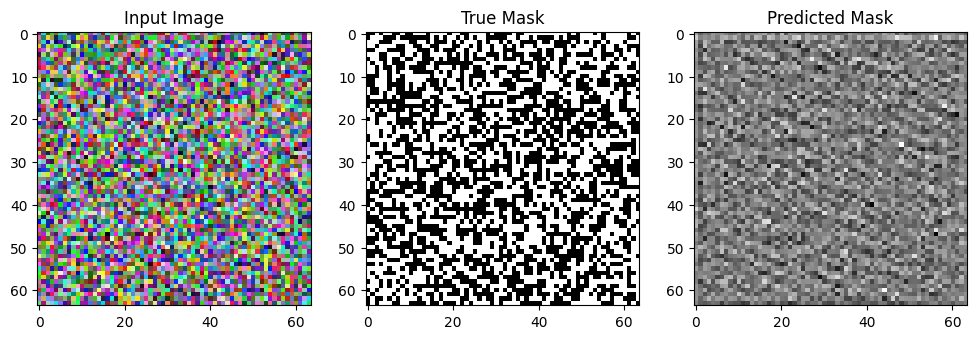

In [5]:
# Modeli yükleme
model = tf.keras.models.load_model('unet_model_small.h5')

# Örnek bir görüntü üzerinde test etme
for image, mask in dataset.take(1):
    pred_mask = model.predict(image)
    # Görüntü ve tahmin maskesini gösterme
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(image[0])
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(mask[0, :, :, 0], cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask[0, :, :, 0], cmap='gray')
    plt.show()
    break


## **Sadece Ağırlıkları Kaydetme**
Bu işlem sadece modelin eğitilmiş ağırlıklarını kaydeder; modelin yapısını (mimarisi) içermez.
Bu yöntemde, modelin mimarisi ve yapısı ayrıca tanımlanmalıdır, ve bu tanım ile ağırlıklar daha sonra modele yüklenebilir.

- **Dosya İçeriği**:
  - Sadece modelin ağırlıkları (her bir katmandaki öğrenilmiş parametreler).
- **Kullanım Durumu**:
  - Modelin yapısı kod içinde zaten tanımlıysa ve sadece farklı veri kümeleri üzerinde eğitilmiş aynı yapıdaki farklı modellerin ağırlıklarını değiştirmek istiyorsanız bu yöntem kullanılır.
  - Model yapısını ayrı bir yerde tanımlayarak, farklı mimariler üzerinde çalışmak ve ağırlıkları uygun olduğunda tekrar kullanmak için de uygundur.

- **Modeli Kaydetme**: Modelin hem yapısını hem de ağırlıklarını kaydeder. Bu, modeli yeniden oluşturmak için gereken tüm bilgileri tek bir dosyada içerir.
- **Sadece Ağırlıkları Kaydetme**: Sadece modelin ağırlıklarını kaydeder. Modelin yapısı ayrıca tanımlanmalıdır.


In [7]:
input_shape = (img_size, img_size, 3)
model_2 = unet_model(input_shape)

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Modeli eğitim
history_2 = model_2.fit(dataset,
                    epochs=5,
                    validation_data=dataset,
                    verbose=1)

model.save_weights('Unet_model.weights.h5')


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 232ms/step - accuracy: 0.4986 - loss: 0.6935 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5030 - loss: 0.6931 - val_accuracy: 0.5055 - val_loss: 0.6931
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5051 - loss: 0.6931 - val_accuracy: 0.5073 - val_loss: 0.6930
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5065 - loss: 0.6931 - val_accuracy: 0.5092 - val_loss: 0.6930
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5087 - loss: 0.6930 - val_accuracy: 0.5058 - val_loss: 0.6930


In [9]:
model_3 = unet_model(input_shape)  # Modelin yapısını yeniden oluşturun
model_3.load_weights('Unet_model.weights.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


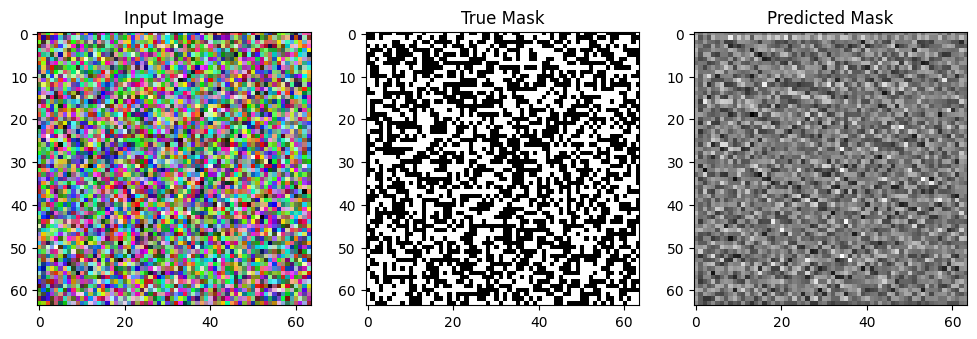

In [11]:
# Örnek bir görüntü üzerinde test etme
for image, mask in dataset.take(1):
    pred_mask = model_3.predict(image)
    # Görüntü ve tahmin maskesini gösterme
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(image[0])
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(mask[0, :, :, 0], cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask[0, :, :, 0], cmap='gray')
    plt.show()
    break
